In [73]:
import mne
import brainflow
import tensorflow as tf
import numpy as np
import random
import time

In [2]:
import matplotlib

In [5]:
from matplotlib import pyplot as plt
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

In [6]:
# Basic BrainFlow setup to get info from OpenBCI
BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
params.serial_port = "COM5"
board = BoardShim(BoardIds.CYTON_DAISY_BOARD, params)

In [43]:
board.prepare_session()
board.start_stream()

BrainFlowError: ANOTHER_BOARD_IS_CREATED_ERROR:16 unable to prepare streaming session

In [118]:
# This is a generic function simulating trial_display.py. Every 5 seconds, it sends a marker to the board corresponding with a random activated/relaxed value.
# When collecting data, we can synchronize this with a display/ command line instructions.
# 2: ACTIVE 3: REST
def collect_n_samples(n, wait_time=5):
    states = [2, 3]
    data = []
    while len(data) < n:
        choice = random.choice(states)
        # Clear the buffer so we don't get old data
        _ = board.get_board_data()
        board.insert_marker(choice)
        time.sleep(wait_time)
        data.append(board.get_board_data())
    return data

In [133]:
# We will collect a small dataset for proof of concept.
y = collect_n_samples(15)

In [134]:
# Note that in this context, num_samples is NOT the amount of data points we have, but the number of different markers sent.
BOARD_ID = BoardIds.CYTON_DAISY_BOARD.value
marker_channel = BoardShim.get_marker_channel(BOARD_ID)
eeg_channels = BoardShim.get_eeg_channels(BOARD_ID)
BoardShim.get_board_descr(BOARD_ID)

{'accel_channels': [17, 18, 19],
 'analog_channels': [27, 28, 29],
 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eeg_names': 'Fp1,Fp2,C3,C4,P7,P8,O1,O2,F7,F8,F3,F4,T7,T8,P3,P4',
 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'gyro_channels': None,
 'marker_channel': 31,
 'name': 'CytonDaisy',
 'num_rows': 32,
 'other_channels': [20, 21, 22, 23, 24, 25, 26],
 'package_num_channel': 0,
 'sampling_rate': 125,
 'timestamp_channel': 30}

In [176]:
# BrainFlow fills in missing markers with 0s. We will use the markers to fill in this data to create labels.
labels = []
for block in y:
    if block[marker_channel][0] == 2:
        tmp = np.array([0])
        [labels.append(tmp) for i in range(len(block[0]))]
    elif block[marker_channel][0] == 3:
        tmp = np.array([1])
        [labels.append(tmp) for i in range(len(block[0]))]
    else:
        print("Error")
labels = np.array(labels)
print(labels)
len(labels)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


9379

In [150]:
# We need to unpack the data.
samples = np.concatenate([y[i][eeg_channels, :] for i in range(len(y))], axis=1)
samples.shape

(16, 9379)

Creating RawArray with float64 data, n_channels=16, n_times=9379
    Range : 0 ... 9378 =      0.000 ...    75.024 secs
Ready.


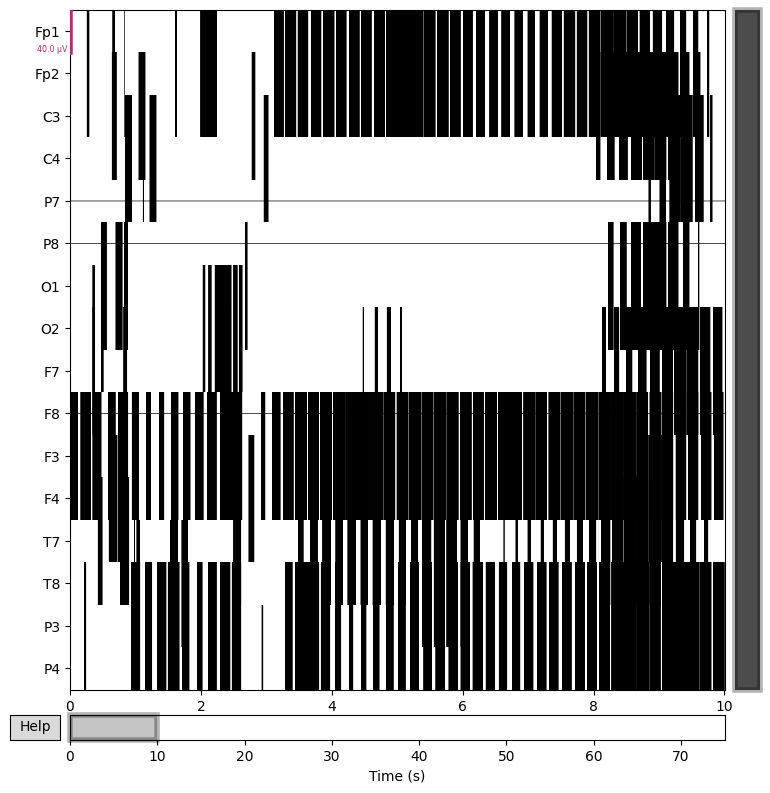

In [151]:
# We now have our samples and labels in the standard NP format. MNE can be used to plot data.
ch_types = ['eeg'] * len(eeg_channels)
ch_names = BoardShim.get_eeg_names(BOARD_ID)
sfreq = BoardShim.get_sampling_rate(BOARD_ID)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(samples, info)
raw.plot();

This is dummy data collected with an empty cap. In the future, filters can be implemented using MNE, SciPy, BrainFlow, numpy,  or manually. A study similar to us used an LSTM network and a stacked autoencoder for feature extraction:
https://www.sciencedirect.com/science/article/pii/S0169260721001966#sec0002
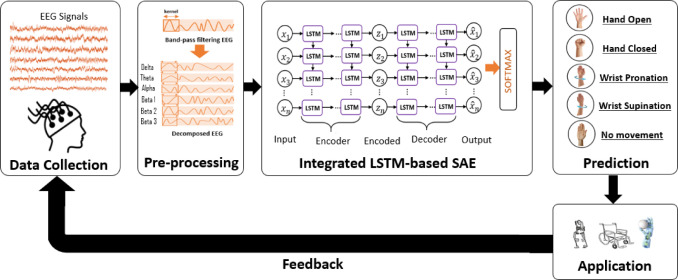
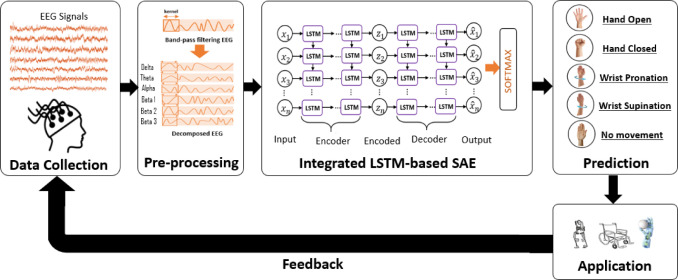

In [177]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(samples.T, labels, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, len(y_train), len(y_test))

(7503, 16) (1876, 16) 7503 1876


In [183]:
# Create a basic LSTM model using Keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(16, 1)))
model.add(layers.LSTM(4))
model.add(layers.Dense(1))

# Optimizer and loss functions can be changed and fine-tuned. 
# I'm using basics for now.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
7503/7503 - 20s - loss: 9.2166 - accuracy: 0.4025 - 20s/epoch - 3ms/step
Epoch 2/10
7503/7503 - 20s - loss: 9.2166 - accuracy: 0.4025 - 20s/epoch - 3ms/step
Epoch 3/10
7503/7503 - 20s - loss: 9.2166 - accuracy: 0.4025 - 20s/epoch - 3ms/step
Epoch 4/10
7503/7503 - 20s - loss: 9.2166 - accuracy: 0.4025 - 20s/epoch - 3ms/step
Epoch 5/10
7503/7503 - 24s - loss: 9.2166 - accuracy: 0.4025 - 24s/epoch - 3ms/step
Epoch 6/10
7503/7503 - 23s - loss: 9.2166 - accuracy: 0.4025 - 23s/epoch - 3ms/step
Epoch 7/10
7503/7503 - 22s - loss: 9.2166 - accuracy: 0.4025 - 22s/epoch - 3ms/step
Epoch 8/10
7503/7503 - 22s - loss: 9.2166 - accuracy: 0.4025 - 22s/epoch - 3ms/step
Epoch 9/10
7503/7503 - 23s - loss: 9.2166 - accuracy: 0.4025 - 23s/epoch - 3ms/step
Epoch 10/10
7503/7503 - 24s - loss: 9.2166 - accuracy: 0.4025 - 24s/epoch - 3ms/step


In [184]:
# Let's evaluate the model
loss = model.evaluate(x_test, y_test, verbose=2)

59/59 - 1s - loss: 9.1185 - accuracy: 0.4088 - 564ms/epoch - 10ms/step


This model is just proof of concept. A study using a similar model achieved 99%+ accuracy with four subjects across multiple motor tasks. They collected around 500s of quality data per subject.
BrainFlow allows easy access to OpenBCI streaming, and can allow us to completely customize data collection and processing relatively simply. It can be combined with MNE/NeuroPype as needed, or plugged into a custom pipeline. 